# Phase diagrams at finite kpar

* Cheat funtion to obtain bubble diagrams from crossing data.

* Limited use since it requires crossings for dense mesh of kpar. Not integrated in the main code.

* Bellow we see application to some data extracted from 11-band model.

In [2]:
import pickle
import numpy as np
import tinyarray as ta
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
import pickle
import os
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
try:
    import mkl
    mkl.set_num_threads(1)
except:
    pass

s0 = ta.array([[1,0], [0,1]])
s1 = ta.array([[0,1], [1,0]])
s2 = ta.array([[0, -1j],[1j, 0]])
s3 = ta.array([[1,0], [0, -1]])

Plot 11-band data

In [3]:
file = 'crossings_mm4nn7_all_kpars.p'
cross_kpars = pickle.load(open(file, 'rb'))

<IPython.core.display.Javascript object>


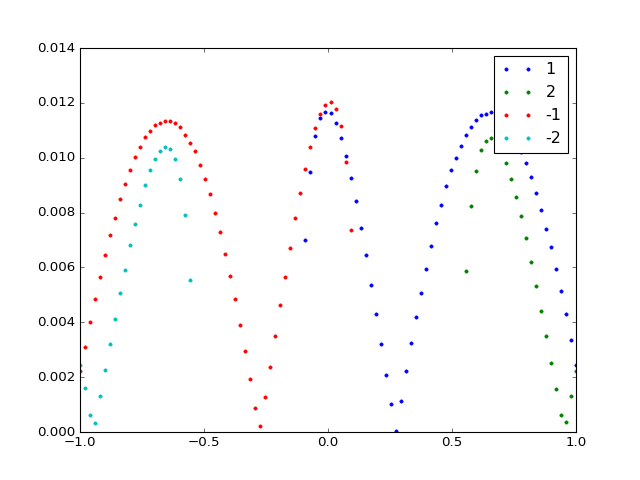

In [4]:
%matplotlib notebook
edge = [-3, 7]
kpar_lim = np.pi/np.sqrt(edge[0]**2+edge[1]**2+edge[0]*edge[1])
for key, value in cross_kpars.items():
    if len(value):
        mus1, mus2, kpars = zip(*value)
        plt.plot(np.array(kpars)/kpar_lim, np.abs(np.array(mus1)-np.array(mus2)), '.', label=key)
        
plt.legend()

Treat Tomas' data in my format.

In [7]:
edge = [-3, 7]

kpar_lim = np.pi/np.sqrt(edge[0]**2+edge[1]**2+edge[0]*edge[1])

# obtain kpars
kpar_list = []
for key, value in cross_kpars.items():
    if len(value):
        mus1, mus2, kpars = zip(*value)
        kpar_list.extend(kpars)

mykpars = np.sort(np.asarray(list(set(kpar_list))))

data = {}

from collections import defaultdict
dataR = defaultdict(list)
dataL = defaultdict(list)

# keys
keysR = np.arange(1, 5)

for key in keysR:
    if len(cross_kpars[key]):
        arr = np.asarray(cross_kpars[key])
        # order by momentum
        arr = arr[np.argsort(arr[:,2])]
        for j in range(len(arr[:, 2])):
            dataR[arr[j, 2]].append(arr[j, 0])
            dataR[arr[j, 2]].append(arr[j, 1])        
            
for key in -keysR:
    if len(cross_kpars[key]):
        arr = np.asarray(cross_kpars[key])
        # order by momentum
        arr=arr[np.argsort(arr[:,2])]
        for j in range(len(arr[:, 2])):
            dataL[arr[j, 2]].append(arr[j, 1])
            dataL[arr[j, 2]].append(arr[j, 0])


# prepare my data
data = {}
for kpar in mykpars:
    data[kpar] = (np.asarray(dataR[kpar]), np.asarray(dataL[kpar]))

In [10]:
def winding_mesh_mu(mu, kpars, sqvd, data):
    """Returns a meshgrid of winding numbers for drawing the phase diagram at fixed my.
    mu : float
        Chemical potential
    sqvd : float
        Array of \sqrt(V^2-\Delta^2)
    kpars : float
        Array of parallel momenta
    data : dict
        Dictionary of crossings. At a given kpar data[kpar] = (dR, dL)
    dR : ndarray 
        Crossings in right BZ (aranged in increasing order in momentum).
    dL : ndarray
        Crossings in left BZ (aranged in decreasing order in momentum).
    """
    def swap(a):
        for j in range(len(a)):
            if j%4 == 3: a[j], a[j-1] = a[j-1], a[j]
        return a

    def point(x, y):
        """Winding number at (x, y).
        """        
        w = 0
        for x in data[x]:
            x = swap(x[~np.isnan(x)])
            
            low = 1 - 2*(np.arange(len(x)) % 2)
            high = np.roll(low, 1)
    
            up = x+y
            down = x-y
            idx_up = np.argwhere(up < mu)
            idx_down = np.argwhere(down < mu)
            w += np.sum(high[idx_up])+np.sum(low[idx_down])
        return w
        
    KPA, V = np.meshgrid(kpars, sqvd)
    return np.array([point(x, y) for (x, y) in zip(KPA.ravel(), V.ravel())]).reshape(V.shape)

In [12]:
mu = 1.831
sqvd = np.linspace(0.0, 0.0125, 400)

kpars = mykpars

Z = winding_mesh_mu(mu, kpars, sqvd, data)

<IPython.core.display.Javascript object>


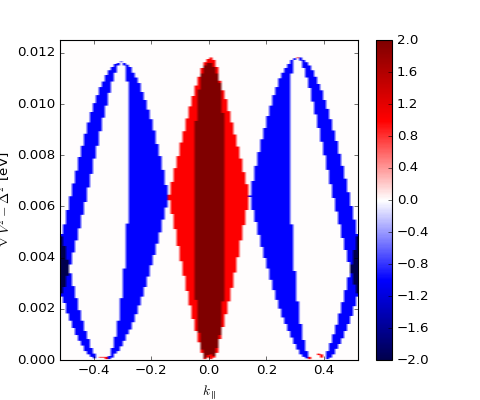

In [15]:
fig = plt.figure(figsize=(6, 5))

plt.imshow(Z, extent = [kpars.min(), kpars.max(), sqvd.min(), sqvd.max()],
           origin='lower', aspect='auto', cmap='seismic')

plt.ylabel('$\sqrt{V^2-\Delta^2}$ [eV]')
plt.xlabel('$k_\parallel$')
plt.colorbar()
# plt.savefig('bubble.png', bbox_inches='tight', dpi=200)
plt.show()